In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import pickle
import cv2
import tensorflow as tf
os.chdir('C:/Users/jonat/Documents/ML/trafficsignclassifier')
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout



### Load data & Labels

In [2]:
baseDir=os.getcwd()
dataDir=os.path.join(baseDir, 'data')
training_file=os.path.join(dataDir,'train.p')
testing_file=os.path.join(dataDir,'test.p')

In [3]:
with open(training_file,'rb') as f:
    train = pickle.load(f)
    
with open(testing_file,'rb') as f:
    test = pickle.load(f)

In [4]:
train.keys()

dict_keys(['sizes', 'coords', 'features', 'labels'])

In [5]:
test.keys()

dict_keys(['sizes', 'coords', 'features', 'labels'])

In [6]:
train['labels']

array([ 0,  0,  0, ..., 42, 42, 42], dtype=uint8)

In [7]:
X_train,y_train=train['features'],train['labels']
X_test,y_test=test['features'],test['labels']

In [8]:
X_train[0].shape

(32, 32, 3)

In [9]:
print('Image Shape:    {}'.format(X_train[0].shape))
print('Training Set:   {} samples'.format(len(X_train)))
print('Test Set:       {} samples'.format(len(X_test)))
##print('Labels in Set:  {}'.format(np.unique(y_train)))
print('Number of unique classes: {}'.format(len(np.unique(y_train))))

Image Shape:    (32, 32, 3)
Training Set:   39209 samples
Test Set:       12630 samples
Number of unique classes: 43


In [10]:
signnames=pd.read_csv('signnames.csv')

In [11]:
from sklearn.utils import shuffle
X_train, y_train=shuffle(X_train, y_train)

In [12]:
from sklearn.model_selection import train_test_split
test_features, valid_features, test_labels, valid_labels= train_test_split(X_test,y_test, test_size=0.60, random_state=42)

In [13]:
print('Number of validation examples = {}'.format(len(valid_labels)))
print('Number of testing examples = {}'.format(len(test_labels)))

Number of validation examples = 7578
Number of testing examples = 5052


In [14]:
print("X_train.shape: {}".format(X_train.shape))
print("valid_features.shape: {}".format(valid_features.shape))
print("y_train.shape: {}".format(y_train.shape))
print("valid_labels.shape: {}".format(valid_labels.shape))

X_train.shape: (39209, 32, 32, 3)
valid_features.shape: (7578, 32, 32, 3)
y_train.shape: (39209,)
valid_labels.shape: (7578,)


### One hot encoding the labels

In [15]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
valid_labels = to_categorical(valid_labels, 43)

In [16]:
print(y_train.shape)
print(valid_labels.shape)

(39209, 43)
(7578, 43)


### Training the model

In [17]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
# We have 43 classes that's why we have defined 43 in the dense
model.add(Dense(43, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(valid_features, valid_labels))

Epoch 1/20
1226/1226 [==============================] - 91s 73ms/step - loss: 1.7987 - accuracy: 0.5398 - val_loss: 0.6119 - val_accuracy: 0.8349
Epoch 2/20
1226/1226 [==============================] - 95s 77ms/step - loss: 0.7031 - accuracy: 0.7871 - val_loss: 0.3882 - val_accuracy: 0.8948
Epoch 3/20
1226/1226 [==============================] - 94s 77ms/step - loss: 0.5447 - accuracy: 0.8345 - val_loss: 0.3467 - val_accuracy: 0.8994
Epoch 4/20
1226/1226 [==============================] - 100s 81ms/step - loss: 0.4790 - accuracy: 0.8526 - val_loss: 0.3233 - val_accuracy: 0.9140
Epoch 5/20
1226/1226 [==============================] - 105s 85ms/step - loss: 0.4187 - accuracy: 0.8706 - val_loss: 0.3139 - val_accuracy: 0.9237
Epoch 6/20
1226/1226 [==============================] - 101s 83ms/step - loss: 0.3833 - accuracy: 0.8846 - val_loss: 0.2772 - val_accuracy: 0.9277
Epoch 7/20
1226/1226 [==============================] - 101s 82ms/step - loss: 0.3642 - accuracy: 0.8888 - val_loss: 0.26

### Loss Curve

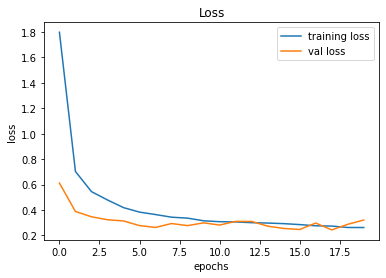

In [20]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Accuracy Curve

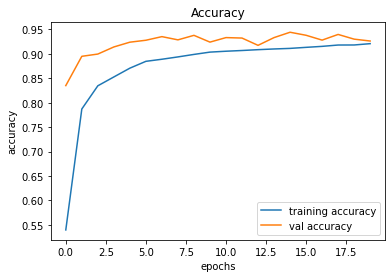

In [21]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Accuracy with the test data

In [22]:
y_pred = np.argmax(model.predict(X_test),axis=1)
y_pred

395/395 [==============================] - 6s 13ms/step


array([16,  1, 38, ...,  8,  7, 10], dtype=int64)

In [23]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.9249406175771971


### Save and load the model

In [24]:
model.save("./training/TSR.h5")

In [30]:
from keras.models import load_model
model = load_model('./training/TSR.h5')

In [31]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }